In [1]:
import sys
sys.path.insert(0, "../..")

import jax
import jax.numpy as jnp

import jax.scipy
import jax.scipy.special

from tqdm import tqdm
from functools import partial

import module.samplers
import module.hamiltonians
import module.wavefunctions

import flax.linen as nn

import optax
import numpy as np
from matplotlib import pyplot as plt

import run.utils
run.utils.path = "../../plots/"

In [2]:
key = jax.random.PRNGKey(0)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
def getLine(phi, theta, r_max = 10):
    r = jnp.linspace(-r_max, r_max, num = 2000)
    x = jnp.cos(phi)*jnp.sin(theta) * r
    y = jnp.sin(phi)*jnp.sin(theta) * r
    z = jnp.cos(theta) * r

    return r, jnp.stack((x,y,z), axis = 1)

## 1. Introduction

In this notebook, we try to demonstrate an LCAO Ansatz combined with a Neural Network to find the ground state of the $\mathrm{H}_2^{+}$ molecule.
The LCAO Ansatz enforces the Kato-cusp condition, which is difficult to model by a Neural Network (singularity of the gradient). The deviations from the LCAO Ansatz are represented by a Neural Network.

Given the nucliei positions $\vec{R_i} $, the potential Energy is:

$$
V = - \sum_{i} \frac{k_i}{|\vec{r} - \vec{R_i}|}
$$

with $k_i = \frac{Z_i e^2}{4 \pi \epsilon_0}$

The solution to the single-nucleus problem is known:

$$
\Phi_i = e^{-\frac{m}{\hbar^2}k_i |\vec{r} - \vec{R_i}|} 
$$

notably satisfying the cusp condition:

$$
Z_k = -\frac{a_0}{2 n} \frac{dn}{dr} \quad\text{for} \lim r \to 0
$$

with $n = |\Psi|^2$.

The resulting Ansatz is thus:

$$
\Psi = \sum_{i} \alpha_i \Phi_i(\vec{r}) \cdot e^{NN(\vec{r})}
$$

and $NN$ is a $C^2$-smooth Neural Network.

Remark: $\hbar = m  = 1$ and $e^2 = 4\pi\epsilon_0$ will be set.

### 1.1 Defining the Potential Energy

In [4]:
class DiPotential:
    def __init__(self, k):
        self.k = k
        self.calc_grad_potential = jax.vmap(jax.grad(self.calc_potential_internal, argnums=1), in_axes=[0, None])
        self.calc_potential = jax.vmap(self.calc_potential_internal, in_axes = [0, None])

    def calc_R(self, dist):
        return jnp.array([[dist/2,0,0],[-dist/2,0,0]])

    def calc_E_nuc(self, dist):
        return self.k[0] * self.k[1] / dist
    
    def calc_potential_internal(self, x, param):
        dist = param["dist"]
        R = self.calc_R(dist)
        d = jnp.sqrt(jnp.sum((x - R)**2, axis = -1))
        return - jnp.sum(self.k/d) + self.calc_E_nuc(dist)

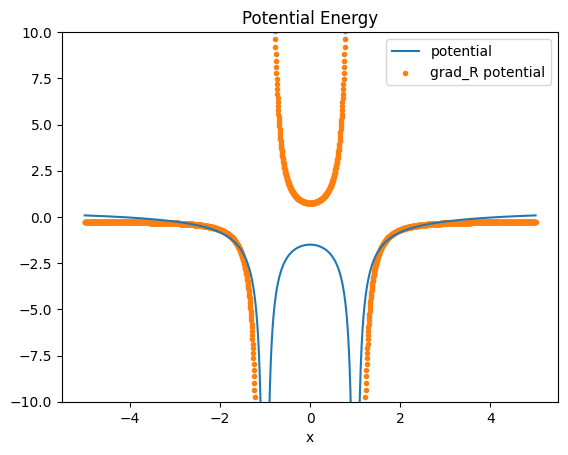

In [5]:
potential = DiPotential(k = jnp.array([1.,1.]))

# the hamiltonian
hamiltonian = module.hamiltonians.Particles(masses = [1], potential = potential.calc_potential)

xs = jnp.linspace(-5, 5, 2000)
pos = jnp.array([xs,xs*0,xs*0])
ys = potential.calc_potential(jnp.swapaxes(pos, 0, 1), {"dist":2.})
ys2 = potential.calc_grad_potential(jnp.swapaxes(pos, 0, 1),{"dist":2.})["dist"]
plt.plot(xs, ys, label = "potential")
plt.scatter(xs, ys2, label = "grad_R potential", marker = ".", color = "C1")
plt.title("Potential Energy")
plt.xlabel("x")
plt.ylim(-10, 10)
plt.legend()

# run.utils.save_plot("The potential of the H2+ ion. The ionic distance is 2")

### 1.2 Defining the Wavefunction

In [6]:
## netket.nn.log_cosh

def act(x):
    return jnp.log(jnp.cosh(x))

class NN(nn.Module):
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(32, name="dense1", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(32, name="dense2", bias_init=jax.random.normal)(x)
        x = act(x)
        x = nn.Dense(1, name="dense5", bias_init=jax.random.normal)(x)
        x = act(x)
        return -jnp.squeeze(x)

In [53]:
class Ansatz(module.wavefunctions.Wavefunction):
    def __init__(self):
        super().__init__(input_shape = (3,))

        self.nn = NN()
        self.lcao = module.wavefunctions.LCAO()

    def init_param(self, key):
        nn_param = self.nn.init(key, jnp.empty((3,)))

        dist = 2.09
        lcao_param = self.lcao.init_parameters(jnp.array([[-dist/2,0.,0.],[dist/2,0.,0.]]), jnp.array([1.,1.]), jnp.array([1.,1.]))
        return {"nn": nn_param,"lcao":lcao_param, "dist": dist}
    
    @partial(jax.jit, static_argnames=['self'])
    def eval_nn(self, parameters, x):
        x_coord = x[:, 0]                              # molecular axis
        r = jnp.sqrt(x[:, 1]**2 + x[:, 2]**2 + 0.1)          # radial distance
        phi = jnp.arctan2(x[:, 2], x[:, 1])            # angle
        r_tot = jnp.sqrt(x[:, 0]**2 + x[:, 1]**2 + x[:, 2]**2 + 0.1)

        coord = jnp.stack((x_coord, r, r_tot), axis = 1)
        coord2 = jnp.stack((-x_coord, r, r_tot), axis = 1)

        return self.nn.apply(parameters, coord) + self.nn.apply(parameters, coord2)

    @partial(jax.jit, static_argnames=['self'])
    def calc_logpsi(self, parameters, x):
        return self.lcao.calc_logpsi(parameters["lcao"], x) + self.eval_nn(parameters["nn"], x)

In [54]:
ansatz = Ansatz()

In [55]:
key, _ = jax.random.split(key)
param = ansatz.init_param(key)

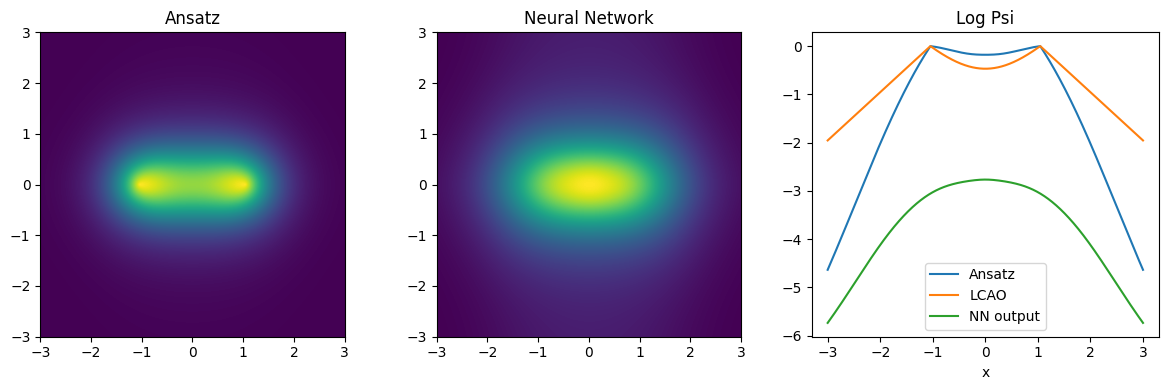

In [56]:
l = 3

f, axs = plt.subplots(1, 3, figsize = (12,4))

xs = jnp.linspace(-l, l, num = 1000)
ys = jnp.linspace(-l, l, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[0].imshow(res, extent = [-l, l, -l, l])
axs[0].set_title("Ansatz")

res = ansatz.eval_nn(param["nn"], im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-l, l, -l, l])
axs[1].set_title("Neural Network")


r, line = getLine(0, jnp.pi/2, r_max=l)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(param["lcao"], line)
nn_out = ansatz.eval_nn(param["nn"], line)

axs[2].plot(r, psi - jnp.max(psi), label = "Ansatz")
axs[2].plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
axs[2].plot(r, nn_out, label = "NN output")

axs[2].set_title("Log Psi")
axs[2].legend()
axs[2].set_xlabel("x")

f.tight_layout()

# run.utils.save_plot("The combination of an LCAO Ansatz with a Neural Network added in the logarithm. Before Optimisation.")

### 1.3 Initialise Sampler

In [57]:
class SymmetrySampler(module.samplers.MCMC):
    def propose(self, key, element):
        subkey, _ = jax.random.split(key)

        mirrorprob = 0.01

        var = jax.random.normal(key, shape = self.shape) * jnp.sqrt(self.variance)
        inv = -element

        decide = jax.random.uniform(key)

        proposal = jnp.where(decide < mirrorprob, inv, element + var)

        return subkey, proposal

In [58]:
sampler = SymmetrySampler(ansatz, 0.5)

Acceptance Ratio: 0.317
Expected Energy: -0.16822682


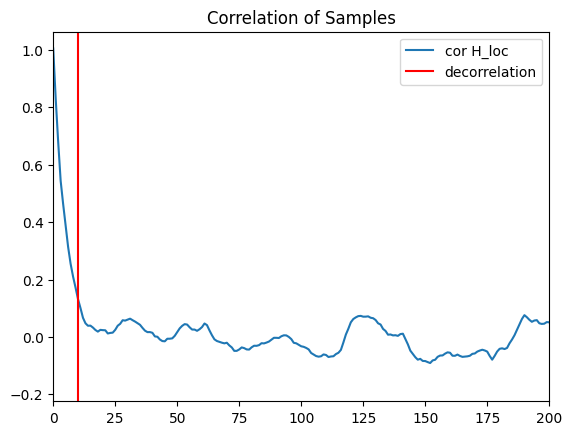

In [59]:
N = 10000
samples, ratio = sampler.sample(key, param, jnp.array([param["dist"]/2 + 0.01, 0, 0]), N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc))

plt.plot(jnp.correlate(H_loc-jnp.mean(H_loc), H_loc[0:2000]-jnp.mean(H_loc))/jnp.std(H_loc[0:2000])**2/2000, label = "cor H_loc")
plt.xlim(0,200)
plt.axvline(10, color = "r", label = "decorrelation")
plt.title("Correlation of Samples")
plt.legend()
plt.show()

In [60]:
subsampling = 15

In [61]:
def get_samples(N):
    """
    Returns decorrelated samples.
    """
    samples, ratio = sampler.sample(key, param, jnp.array([param["dist"]/2 + 0.01, 0, 0]), N*subsampling)
    return samples[0:-1:subsampling], ratio

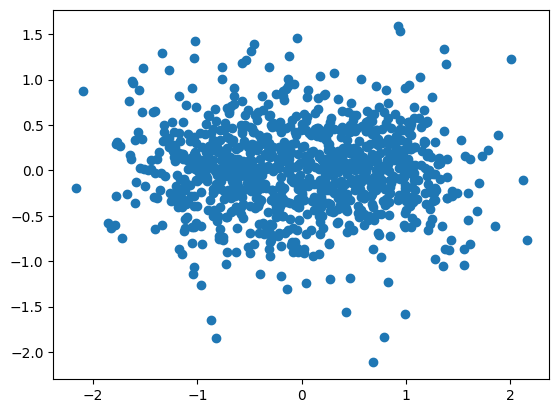

In [62]:
samples, ratio = get_samples(1000)
plt.scatter(samples[:, 0], samples[:, 1])

## 2. Energy Minimisation
The energy is calculated as such:
$$
\langle E \rangle = \langle \Psi | H | \Psi \rangle
$$
When the inter-nuclei distance is an variational parameter, then three terms result, by chain rule:

$$
\partial_R \langle E \rangle = \left[\partial_R \langle \Psi | \right] \,H | \Psi \rangle +  \langle \Psi | \,\partial_R H \, | \Psi \rangle +  \langle \Psi | H \partial_R \, \left[| \Psi \rangle \right]
$$

The first and last term are already incorporated in the calculation. The middle term is a new term, which also results by Hellmann-Feynman theorem.


In [63]:
@partial(jax.jit, static_argnames=['hamiltonian', 'orbital'])
def calc_grad_E(hamiltonian, orbital, parameters, samples):
    """
    Calculates the gradient of the energy and the energy itself on a batch of samples.
    """
    E_loc = hamiltonian.calc_H_loc(orbital, parameters, samples)
    E = jnp.mean(E_loc)
    dE = jnp.std(E_loc)
    grad_log = orbital.grad_logpsi(parameters, samples)

    m = lambda tree: 2*jnp.real(jnp.mean(jnp.swapaxes(jnp.swapaxes(tree, 0, -1) * (E_loc - E), 0, -1), axis = 0))
    gradPsi = jax.tree_util.tree_map(m, grad_log)

    gradR = jax.tree_util.tree_map(lambda x: jnp.mean(x), potential.calc_grad_potential(samples, parameters))

    return gradPsi, gradR, E, dE

In [64]:
stats = {"E":[], "dE":[], "ratio":[], "N_samples": [], "dist":[]}
param = ansatz.init_param(key)

def map_nested_fn(fn):
  '''Recursively apply `fn` to the key-value pairs of a nested dict'''
  def map_fn(nested_dict):
    return {k: (map_fn(v) if isinstance(v, dict) else fn(k, v))
            for k, v in nested_dict.items()}
  return map_fn

def mapper(k,_):
  if k == "dist":
    return "dist"
  return "nn"
label_fn = map_nested_fn(mapper)

optimizer = optax.multi_transform({'nn': optax.adam(0.001), 'dist': optax.sgd(0.00001)}, label_fn)
optimizer_state = optimizer.init(param)

In [67]:
N = 3000
epoch = 1200

for i in tqdm(range(epoch)):
    key, _ = jax.random.split(key)
    samples, ratio = get_samples(N)
    gradPsi, gradR, E, dE = calc_grad_E(hamiltonian, ansatz, param, samples)

    total_grad = jax.tree_util.tree_map(lambda x,y:x+y, gradPsi, gradR)

    stats["E"].append(E)
    stats["dE"].append(dE)
    stats["ratio"].append(ratio)
    stats["N_samples"].append(N)
    stats["dist"].append(param["dist"])
    
    updates, optimizer_state = optimizer.update(total_grad, optimizer_state, param)

    param["nn"] = jax.tree_util.tree_map(lambda a,b:a+b,param["nn"], updates["nn"])
    param["dist"] = jax.tree_util.tree_map(lambda a,b:a+b,param["dist"], updates["dist"])
    newR = param["lcao"]["R"].at[0,0].set(param["lcao"]["R"][0,0] - updates["dist"] / 2)
    newR = newR.at[1,0].set(param["lcao"]["R"][1,0] + updates["dist"] / 2)
    param["lcao"]["R"] = newR

100%|██████████| 1200/1200 [05:01<00:00,  3.98it/s]


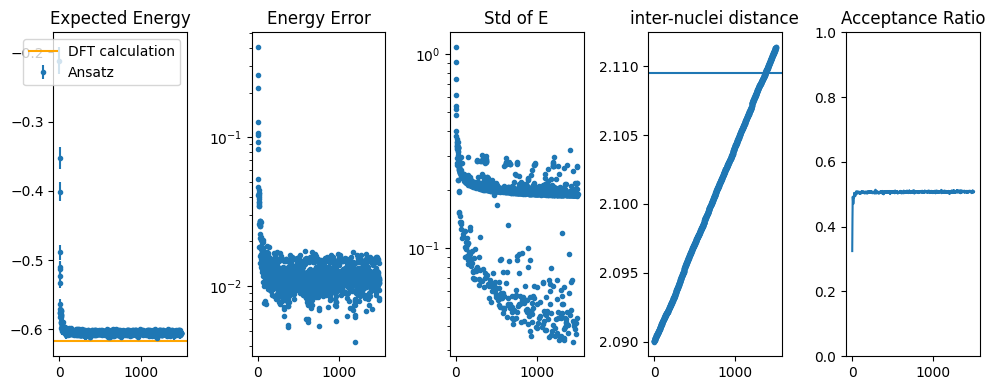

In [68]:
numpy_stats = {}
for key_ in stats.keys():
    numpy_stats[key_] = np.array(stats[key_])

f, ax = plt.subplots(1, 5, figsize = (10, 4))
i = np.arange(len(stats["E"]))

ax[0].errorbar(i, numpy_stats["E"], yerr = numpy_stats["dE"]/jnp.sqrt(numpy_stats["N_samples"]), fmt = ".", label = "Ansatz")
# ax[0].fill_between(i, numpy_stats["E"] - numpy_stats["dE"], numpy_stats["E"] + numpy_stats["dE"], alpha = 0.5)
ax[0].set_title("Expected Energy")
ax[0].axhline(-0.616515, label = "DFT calculation", color = "orange")
ax[0].legend(loc = "upper right")
# ax[0].set_ylim(-0.62, -0.56)

ax[1].scatter(i, jnp.abs(numpy_stats["E"]+0.616515) , label = "error", marker = ".")
ax[1].set_title("Energy Error")
ax[1].set_yscale("log")

ax[2].scatter(i, stats["dE"], marker = ".")
ax[2].set_title("Std of E")
ax[2].set_yscale("log")

ax[3].scatter(i, stats["dist"], marker = ".")
ax[3].set_title("inter-nuclei distance")
ax[3].axhline(2.1095)

ax[4].plot(stats["ratio"])
ax[4].set_ylim(0,1)
ax[4].set_title("Acceptance Ratio")

f.tight_layout()

# run.utils.save_plot("Using the Hellmann-Feynmann theorem, the algorithmn does not converge towards the correct energy. Interestingly, the variance of E still decreases.")

Text(0.5, 1.0, 'Neural Network')

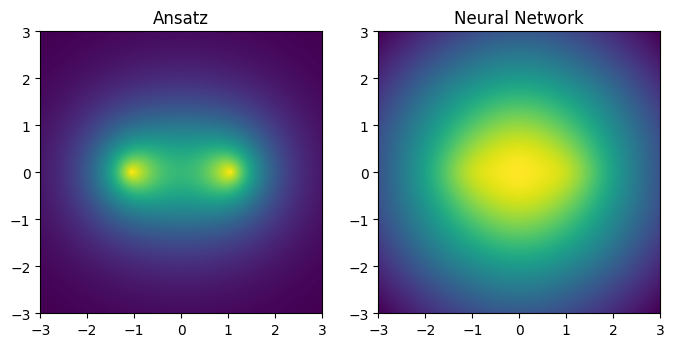

In [69]:
f, axs = plt.subplots(1, 2, figsize = (8,4))

xs = jnp.linspace(-l, l, num = 1000)
ys = jnp.linspace(-l, l, num = 1000)
xss, yss = jnp.meshgrid(xs, ys)
im = jnp.stack((xss, yss, jnp.ones_like(xss) * 0), axis = 2)

res = ansatz.calc_psi(param, im.reshape(-1, 3)).reshape(xss.shape)
axs[0].imshow(res, extent = [-l, l, -l, l])
axs[0].set_title("Ansatz")

res = ansatz.eval_nn(param["nn"], im.reshape(-1, 3)).reshape(xss.shape)
axs[1].imshow(jnp.exp(res), extent = [-l, l, -l, l])
axs[1].set_title("Neural Network")

# run.utils.save_plot("The optimised H2+ wavefunction.")

Text(0.5, 0, 'x')

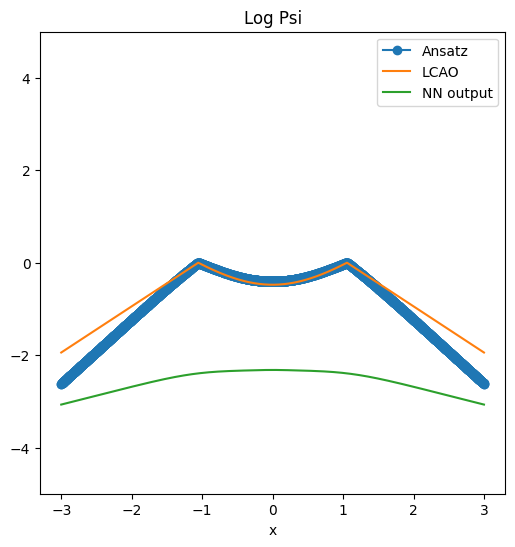

In [70]:
plt.figure(figsize=(6, 6))

r, line = getLine(0, jnp.pi/2, r_max=l)
psi = ansatz.calc_logpsi(param, line)
psi_lcao = ansatz.lcao.calc_logpsi(param["lcao"], line)
nn_out = ansatz.eval_nn(param["nn"], line)
ys = potential.calc_potential(line, param)

plt.plot(r, psi - jnp.max(psi), label = "Ansatz", marker = "o")
plt.plot(r, psi_lcao - jnp.max(psi_lcao), label = "LCAO")
plt.plot(r, nn_out, label = "NN output")
# plt.plot(r, -ys-5)

plt.ylim(-5, 5)
plt.title("Log Psi")
plt.legend()
plt.xlabel("x")

# run.utils.save_plot("The neural network corrects certain parts of the LCAO Ansatz. Especially in between the nuclei.")

In [71]:
N = 10000
samples, ratio = get_samples(N)
H_loc = hamiltonian.calc_H_loc(ansatz, param, samples)
print("Acceptance Ratio:", ratio)
print("Expected Energy:", jnp.mean(H_loc),"+/-", jnp.std(H_loc)/jnp.sqrt(N))
print("Std of Expected Energy:", jnp.std(H_loc))
print("Energy Error:", jnp.abs(jnp.mean(H_loc)+0.616515))
print("Relative Error:", jnp.abs(jnp.mean(H_loc)+0.616515)/0.616515 * 100, "%")

Acceptance Ratio: 0.50726664
Expected Energy: -0.6021876 +/- 0.0010924011
Std of Expected Energy: 0.10924011
Energy Error: 0.014327407
Relative Error: 2.323935 %
